In [1]:
import sys

!{sys.executable} -m pip install torch
!{sys.executable} -m pip install qiskit
!{sys.executable} -m pip install pylatexenc
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install itertools

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.2.8/libexec/bin/python3.8 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
You should consider upgrading via the '/usr

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_SHOTS = 5000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools

def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['00', '01', '10', '11']


# Contruct QuantumCircuit QFT Class

In [8]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.thetas = { k: Parameter('Theta'+str(k)) for k in range(self.n_qubits) }
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
            
        self.circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def N_qubits_expectation_Z(self, counts, shots, n_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) / shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        
        job_sim = execute(self.circuit, 
                          self.backend, 
                          shots = self.shots, 
                          parameter_binds = [{ self.thetas[k]: params[k].item() for k in range(self.n_qubits) }])
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.N_qubits_expectation_Z(counts, self.shots, self.n_qubits)

Expected value for rotation [pi/4]: [0.0244 0.1206 0.1192 0.7358]


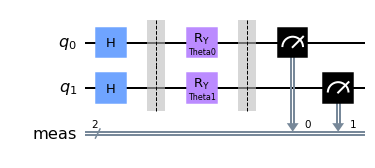

In [9]:
circuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print(f'Expected value for rotation [pi/4]: {circuit.run(torch.Tensor([np.pi/4] * len(QC_OUTPUTS)))}')
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuantumCircuit'):
            ctx.QuantumCircuit = QuantumCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QuantumCircuit.run(i)
        
        result = torch.Tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor,i = ctx.saved_tensors
        
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QuantumCircuit.run(shift_right)
            expectation_left = ctx.QuantumCircuit.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradient = gradient / torch.norm(gradient)
            
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4] * NUM_QUBITS, requires_grad=True)
qc = TorchCircuit.apply

y1 = qc(x)
print(f'y1 after quantum layer: {y1}')
y1 = nn.Linear(2**NUM_QUBITS, 1)(y1.float())

y1.backward()
print(f'x.grad = {x.grad}')

y1 after quantum layer: tensor([[0.0224, 0.1230, 0.1214, 0.7332]], grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.3499, -0.0453])


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


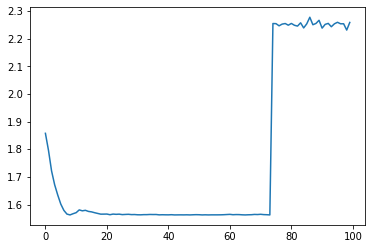

In [12]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    
    val = sum([(i + 1) * expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    
    return torch.abs(target - val) ** 2, expval


x = torch.tensor([-np.pi/4] * NUM_QUBITS, requires_grad=True)
opt = optim.Adam([x], lr = 0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)
    
plt.plot(loss_list)

In [13]:
from torch.functional import F

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 100

X_train = datasets.FashionMNIST(root='./data', 
                                train=True,
                                download=True,
                                transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

In [15]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

In [16]:
n_samples = 100

X_test = datasets.FashionMNIST(root='./data', 
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

In [17]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Building network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 3) # TODO: is this correct ???
        
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
        MODE = 'QC'
        
        if MODE == 'QC':
            x = self.qc(x[0])
        else:
            x = self.qcsim(x)
            
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        
        return x
    
    
    def predict(self, x):
        
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [19]:
epochs = 20
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss) / len(total_loss))
    progress = 100.0 * (epoch + 1) / epochs
    
    print(f'Training [{int(progress)}%]\tLoss {loss_list[-1]}')

Training [5%]	Loss 1.9974147221446037
Training [10%]	Loss 1.9668374279141425
Training [15%]	Loss 1.9487942796945572
Training [20%]	Loss 1.9319228407740594
Training [25%]	Loss 1.9196552923321724
Training [30%]	Loss 1.9138705769181252
Training [35%]	Loss 1.9118121564388275
Training [40%]	Loss 1.915171950161457
Training [45%]	Loss 1.9092899110913277
Training [50%]	Loss 1.9084843444824218
Training [55%]	Loss 1.9032768833637237
Training [60%]	Loss 1.9052339059114456
Training [65%]	Loss 1.9022139728069305
Training [70%]	Loss 1.901128540635109
Training [75%]	Loss 1.9018109330534936
Training [80%]	Loss 1.9014237174391746
Training [85%]	Loss 1.8988950183987618
Training [90%]	Loss 1.8992356058955193
Training [95%]	Loss 1.8971051982045173
Training [100%]	Loss 1.8960626769065856


Text(0, 0.5, 'loss')

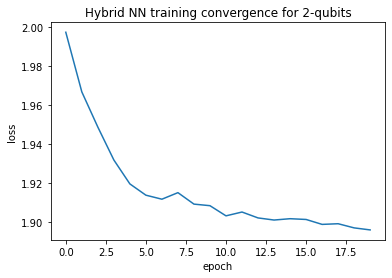

In [20]:
plt.plot(loss_list)
plt.title(f'Hybrid NN training convergence for {NUM_QUBITS}-qubits')
plt.xlabel('epoch')
plt.ylabel('loss')

# Test accuracy

In [21]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number += 1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [22]:
print(f'Performance on test data: {accuracy}/{number} = {accuracy/number*100}%')

Performance on test data: 344/400 = 86.0%


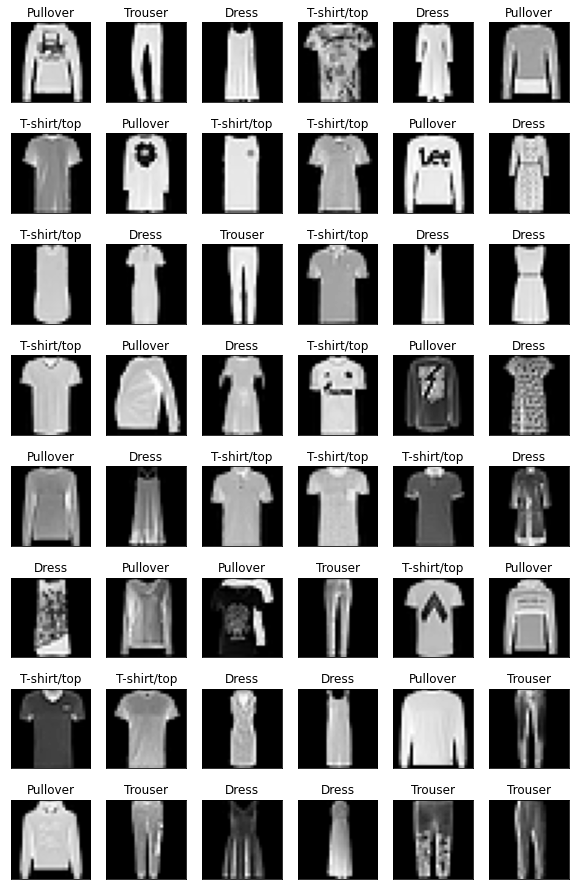

In [23]:
n_sample_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_sample_shape[0], ncols=n_sample_shape[1], figsize=(10, 2*n_sample_shape[0]))

classes_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_sample_shape[0]*n_sample_shape[1]:
            break
        
        prediction = network.predict(data).item()
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_xticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_yticks([])
        axes[count // n_sample_shape[1]][count % n_sample_shape[1]].set_title(classes_map[prediction])
        
        count += 1